In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     if pmin <= param <= pmax
#         return param
#     elseif param < pmin
#         return pmin
#         # param = pmin
#     else
#         return pmax
#         # param = pmax
#     end
#     # return param
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

# function alpha(p, t)
#     Tₐ = limit_func(p[2],0,15)
#     Tₚ = 30 - 2*Tₐ#p[3]
#     αmin = limit_func(p[4],0.5,1)
#     abs_slope = (1 - αmin)/Tₐ
#     if t < Tₐ
#         return 1 - abs_slope * t
#     elseif t > Tₐ + Tₚ
#         return αmin + abs_slope * (t - Tₐ - Tₚ)
#     else
#         return αmin
#     end
# end

function alpha(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[1],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

# dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
# ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

# function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
#     if Tₐ < t < Tₐ + Tᵣ
#         arg = pi / 2 * (t - Tₐ) / Tᵣ
#         E *= sin(arg)^2
#         Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
#     elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
#         E *= 1
#         Edot *= 0
#     elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
#         arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
#         E *= sin(arg)^2
#         Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
#     else
#         E *= 0
#         Edot *= 0
#     end
#     return (E, Edot)
# end

# function pulse2(p, t)
#     Tₐ = limit_func(p[2],0,15)
#     Tₚ = 30 - 2*Tₐ#p[3]
#     Tᵣ = limit_func(p[1],0,Tₚ/2)
#     # αmin = p[4]
#     ϕ = p[5]
#     f = p[6]
#     A = p[7]
#     # Φ_ext = p[8]
#     λ = p[9]

#     amp = pi * A #/ (Tₚ - Tᵣ)
#     E = amp
#     Edot = copy(amp)
#     # E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
#     arg = f*(t - Tₐ) + ϕ
#     return E*cos(arg) + Edot*λ*sin(arg)
# end

# function envelope(t)
#     if t < 2
#         return sin(pi/4*t)^2
#     elseif 28 < t <= 30
#         return cos(pi/4*(t-28))^2
#     else
#         return 1
#     end
# end

h_times = LinRange(10,20,50+2)[2:end-1]
dt = h_times[2] - h_times[1]
function pulse(p, t)
    if  t < 10 || t > 20
        return 0
    end
    out = 0
    w_start = exp( - 5/(2*dt^2) * (t - 10)^2)
    w_end = exp( - 5/(2*dt^2) * (t - 20)^2)
    w_sum = w_start + w_end
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i+1] * w
        w_sum += w
    end
    # envelope(t)*out/w_sum
    out/w_sum
end

# dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [122]:
# #[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# # p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# # p = [3.65, #14.84292607534555
# # 11.341751839758764,
# # 10.0,
# # 0.501, #-649.7661732132904
# #  0.5828557110984577,
# # -7.161153490188593,
# #  1.3640811715268795,
# # -22.06506034791423,
# # -4.957612200539009]
# p = [2, 10, 10, 0.6, 0.0, 1.5*2.482542369189332, 1.5/0.2949509890806259, 0.995pi, 0.0]
# # p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]


# p[1] = inv_limit_func(p[1],0,15 - p[2])
# p[2] = inv_limit_func(p[2],0,15)
# p[4] = inv_limit_func(p[4],0.5,1)
p = cat([inv_limit_func(0.55,0.5,1)],zeros(50),dims=1)

51-element Vector{Float64}:
 -2.1972245773362182
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [151]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

# fu0 = ψs[:,1:2]

# N=30
# # Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
# Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
# Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = ψs[:,1:2]#zeros(N,2)
# ψ0[1,1] = 1.0
# ψ0[2,2] = 1.0

# u0 = ψs[:,1:2]#cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

Hphimærke = dPot3_dphi(phi_ext)
Hphi = KinPot12 + Potential3
IdNH = diagm(ones(ComplexF64, NHilbert))
E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(ψ0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)

sizep = length(p)
m = 0.015/pi

0.00477464829275686

In [152]:
log10(0.015)

-1.8239087409443189

In [153]:
function f!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
    du[:,3:4] = -im .* (H * ψ) - alpha(p,t) .* ((M - M') * x)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

l1sscale = m

function b!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    λ = u[:,5:6]
    ϕ = u[:,7:8]
    ps = u[:,9]
    α = alpha(p,t)
    dαdp = dalphadp(p,t)
    dpdp = dpulsedp(p,t)

    miH = -im .* (KinPot12 + α .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * ψ - α * dUa * x
    du[:,5:6] = miH * λ
    du[:,7:8] = miH * ϕ + α * dUa * λ
    
    du[1:sizep,9] = 2 .* (
    - real(im * tr(λ' * Uv * x)) .* dpdp
    - real(im * tr(λ' * Ua * x)) .* dαdp )
    
    du[8,9] = 2 * real(tr(λ' * dUa * x) * α)
    
    du[sizep+1:2*sizep,9] = 2 .* (
    - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpdp 
    - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dαdp 
    # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
    - real(tr(x' * dUa * λ)) .* dαdp )
    # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
end

b! (generic function with 1 method)

In [154]:
ls = []
l2s = []
params = []
counter = [0]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        counter[1] += 1
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # DT = sol_f.u[end][:,1]
        # UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        # UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][:,1:2]
        ψT = sol_f.u[end][:,3:4]

        λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        ϕ = 0.5 .* cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,9])

        loss[1] = infidelity + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,9]) + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])
        grad[8] = 0

        push!(ls, copy(infidelity))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))

        if counter[1]%5 == 0
            image = plot([ls,ls + m .* abs.(l2s)],yscale=:log10,ylim=(1e-5,2))
            savefig(image,"tmp_loss.png")

            writedlm("tmp_awg55_lsm18.txt",ls)
            writedlm("tmp_awg55_l2sm18.txt",l2s)
            writedlm("tmp_awg55_paramsm18.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    println(ls[end]," ",l2s[end]," ",loss[1])
end


get_grad! (generic function with 1 method)

In [155]:
initial_p = copy(p)
last_p = similar(initial_p);

In [156]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

0.9974570225374297 -0.5993371355440256 1.0003186465684408


0.9962914320068587 -0.737013148093352 0.999810410576142


0.989779057878112 -1.255498336573372 0.9957736208673912


0.9547564626189913 -1.1567592908499233 0.9602795813921785


0.9980200234327209 0.05787253810491169 0.998296344447981


0.966060915111689 0.03945182193735945 0.9662492836859484


0.996736719800813 0.8129667864388609 1.0006183502797514


0.98483816330998 -0.08603862293119084 0.9852489674740695


0.9650787777347666 -0.29235057768743133 0.9664746489214083


0.9655598145016414 -0.07829503439341554 0.9659336457539393


0.9439176800978617 -2.2531764594416828 0.9546758052332148


0.990371254860186 -1.0967576734242102 0.9956078870131688


0.9956271130236917 0.020684563251748944 0.9957258745383081


0.9761546419995254 2.960375174585295 0.9902893922727789


0.9456825994227378 -1.6598655237314823 0.9536078735118283


0.9551553581040373 0.5135403160669995 0.9576073324974084


0.9484824998736253 -0.8914091851212007 0.952738665217512


0.9527469836809417 0.05670209683907595 0.9530177162508101


0.9505708945027439 -0.4012400410126666 0.9524866745795507


0.9520019508622788 -0.09480219575205756 0.9524545980043759


0.9956341228114027 0.8922463783404041 0.9998942854584643


0.9994993900212252 -0.11517355436548603 1.0000493032359472


0.9891950067823969 -0.7792055777511225 0.9929154393639129


0.9465293913537128 0.10954827397282758 0.9470524458330116


0.9601231286736537 1.33862835849471 0.9665146082801763


0.9521414225962804 -4.782822964524426 0.9749777200984053


0.9463629042236221 -0.6804263946943127 0.949611700947396


0.9464675329841933 -0.05002610766926108 0.9467063900537696


0.9464944156514675 0.023906984290152037 0.9466085630931934


0.9464796456549858 -0.015660682537302635 0.9465544199061259


0.9464863823078414 0.0026756595156373457 0.9464991576409798


0.9464827455759851 -0.007156076786120623 0.9465169133257948


0.9464853604835262 -6.134314706678243e-5 0.9464856533754786


0.9464858349718088 0.0012103887366407872 0.9464916141523237


0.9464854328186435 0.0001380972403312464 0.9464860921843963


0.9464853786043923 -5.641295014139841e-6 0.9464854055395919


0.9464853957289664 1.521254624518453e-5 0.9464854683635243


0.9464853881317423 -7.1988230616352875e-6 0.9464854225035906


0.946485372370031 -2.5085561662993084e-6 0.9464853843475045


0.9464853879423983 -8.601133620821111e-6 0.9464854290097863


0.946485372370031 -2.5085561662993084e-6 0.9464853843475045


0.9945492345400773 -0.05452361115593599 0.9948095656069978


0.9977024439660642 -0.12567624632597685 0.9983025038410246


0.9979836873346544 -0.25691131211855434 0.9992103484924512


0.9963911056629366 0.8317384421516938 1.0003623641957764


0.9988977668696883 -1.0220109993550441 1.0037775099429376


0.9838662208935149 5.544456127935042 1.0103390488790254


0.9729603344703099 -0.8000547095126213 0.9767803143231965


0.9579459319029537 4.962914585011883 0.9816421035533789


0.9469302129123404 0.7566672745449144 0.9505430330229312


0.9465259260918444 0.10105701885890135 0.9470084378144101


0.946490481403205 0.01353596411597655 0.9465551108711622


0.946486065308672 0.001813745615814169 0.94649472530608


0.9464854757774975 0.00021877200175245425 0.9464865203368622


0.9464853978368122 2.4225122490865947e-5 0.9464855135032519


0.9464853791157848 -7.803759554722034e-6 0.946485416375992


0.9464853842838296 -2.0401533372897776e-5 0.9464854816939761


0.946485385224254 -1.8915966545521063e-5 0.9464854755413413


0.946485372370031 -2.5085561662993084e-6 0.9464853843475045


 * Status: success

 * Candidate solution
    Final objective value:     9.464854e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.84e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   2862  (vs limit Inf)
    Iterations:    5
    f(x) calls:    59
    ∇f(x) calls:   59


In [157]:
writedlm("tmp_awg55_lsm18.txt",ls)
writedlm("tmp_awg55_l2sm18.txt",l2s)
writedlm("tmp_awg55_paramsm18.txt",params)

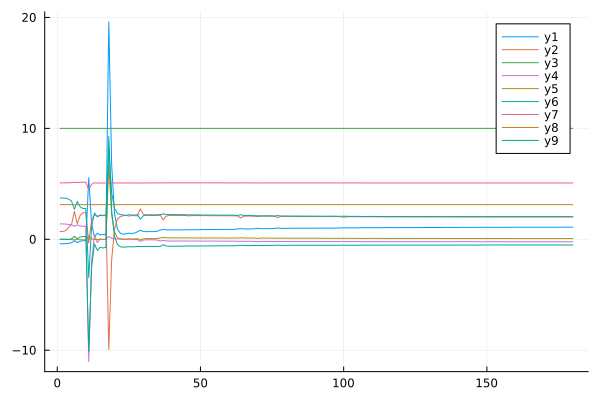

In [34]:
params = readdlm("tmp1_paramsm0.txt")
plot(params)
# function limit_func(param,pmin,pmax)
#     (pmax - pmin) * (1/(1 + exp(-param))) + pmin
# end
# limit_func(params[end,4],0.5,1)
# params[end,6]

In [ ]:
#2120 minutes
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,GradientDescent(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

In [9]:
params = readdlm("tmp_paramsm5.txt") ;

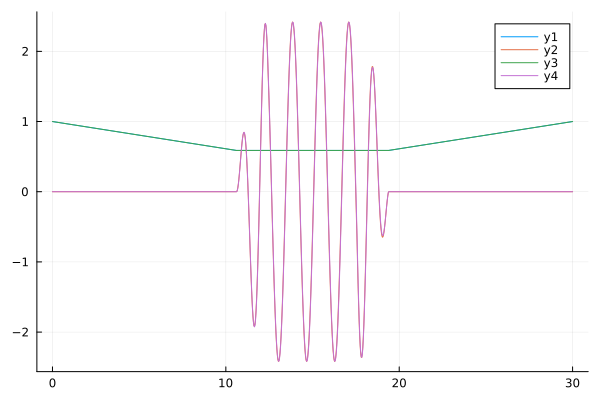

In [11]:
times = LinRange(0,30,1000)
plot(times, [[alpha(params[end,:],t) for t in times],
             [pulse(params[end,:],t) for t in times],
             [alpha(params[end-1000,:],t) for t in times],
             [pulse(params[end-1000,:],t) for t in times]])

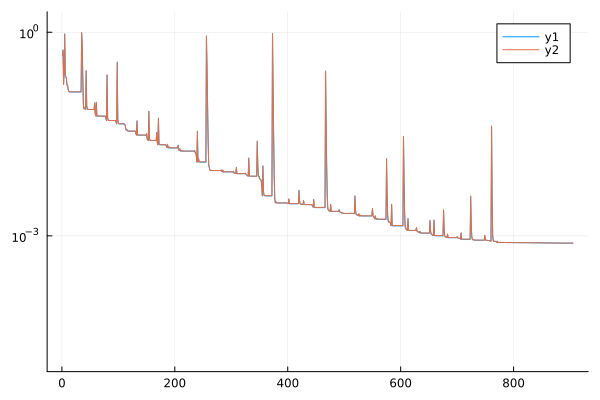

In [22]:
plot([l1s,l1s + m .* abs.(l2s)],yscale=:log10,ylim=(1e-5,2))

In [23]:
res

 * Status: success

 * Candidate solution
    Final objective value:     7.825282e-04

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 8.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.30e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.59e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.42e-07 ≤ 1.0e-06
    |g(x)|                 = 4.98e-03 ≰ 1.0e-04

 * Work counters
    Seconds run:   38952  (vs limit Inf)
    Iterations:    216
    f(x) calls:    905
    ∇f(x) calls:   905


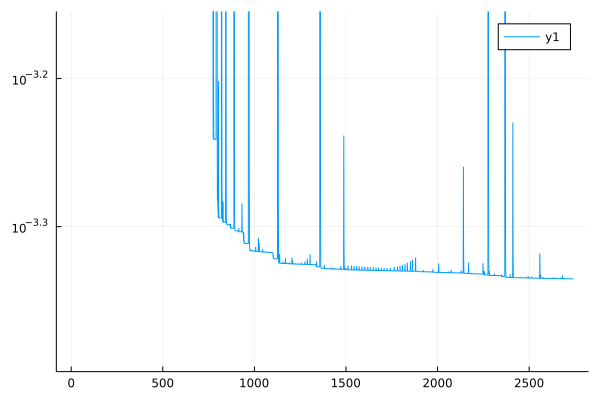

In [30]:
# p_new = copy(Optim.minimizer(res))
# p_new = 
# l1s = readdlm("tmp_l1sm5.txt")
# l2s = readdlm("tmp_l2sm5.txt")

plot(l1s + 0.00001/pi .* l2s, yscale=:log10,ylim=(4e-4,7e-4))

In [33]:
p_new = copy(params[900,:])

9-element Vector{Float64}:
 -0.33689084560238786
  0.8916124355770876
 10.0
 -1.5452864090031917
  0.021122918027769996
  3.8630067360208753
  5.328695497246762
  8.666934882990084
  0.6317148492688623

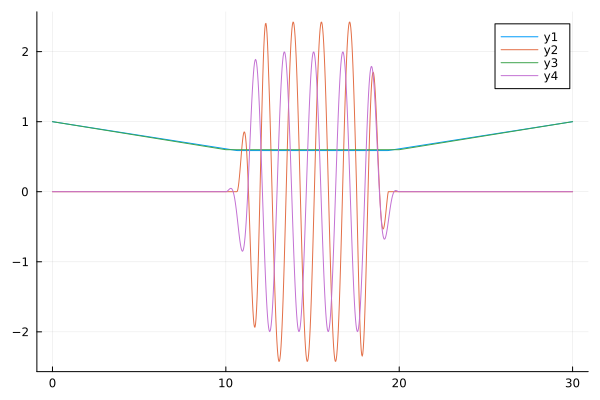

In [34]:
times = LinRange(0,30,1000)
plot(times, [[alpha(p_new,t) for t in times],
             [pulse(p_new,t) for t in times],
             [alpha(p,t) for t in times],
             [pulse(p,t) for t in times]])

In [101]:

forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-8, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im -12.694746782963147 - 24.455949616205622im … 0.13560581855983922 - 0.003927337058381834im 1.5689136759460285 - 0.0003555829988387263im; 1.5438914136931459 + 0.0im 0.23667702089969844 + 1.2094738031882772im … -1.5663165375257906 + 0.0001457230034430623im 0.15108147293050328 - 0.028458648593590374im; … ; 62.82746547287959 + 0.0im 0.8744911662307878 + 0.12239605119046967im … -0.00379360492421821 - 0.0001114663597984746im -0.006882839454721343 - 0.0004503534515507462im; 63.66542063788365 + 0.0i

In [28]:
# writedlm("tmp_l1sm4.txt",l1s)
# writedlm("tmp_l2sm4.txt",l2s)
# writedlm("tmp_paramsm4.txt",params)
# writedlm("tmp_callsm4.txt",calls)

In [145]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-8, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [146]:
phis = cat([0.993,0.99325,0.9935,0.99375,0.994],LinRange(0.994,0.99475,7)[2:end-1],LinRange(0.99475,0.995,7),dims=1)
phis = cat(phis, reverse(0.995 .+ (0.995 .- phis))[2:end],dims=1)
;

In [147]:
p_new = copy(Optim.minimizer(res)) ;

In [150]:
# writedlm("Phils_awg55m1.txt",tmp_losses55_1)
# writedlm("Phils_awg55m2.txt",tmp_losses55_2)
# writedlm("Phils_awg55m3.txt",tmp_losses55)
# writedlm("Phils_awg7m3.txt",tmp_losses)
# writedlm("Phils_awg55m0.txt",tmp_losses55_0)
# writedlm("Phils_awg55m23.txt",tmp_losses55_23)

In [148]:
tmp_losses55_23 = []
for phi in phis
    push!(tmp_losses55_23,fidel(phi*pi,p_new))
end

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


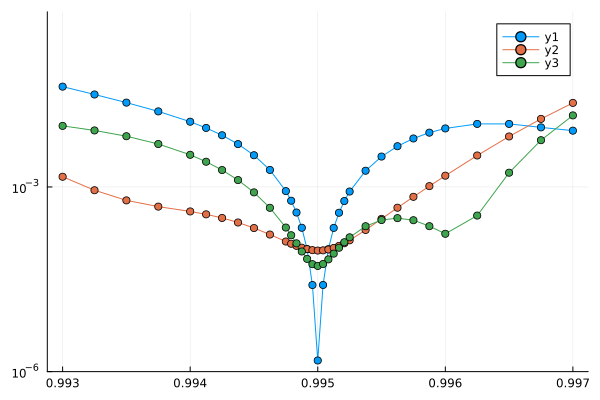

In [149]:
# plot(phis,[tmp_losses,tmp_losses55,tmp_losses55_2,tmp_losses55_0],yscale=:log10,marker="o",ylim=(3e-6,7e-1))
plot(phis,[tmp_losses55_0,tmp_losses55_2,tmp_losses55_23],yscale=:log10,marker="o",ylim=(1e-6,7e-1))

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


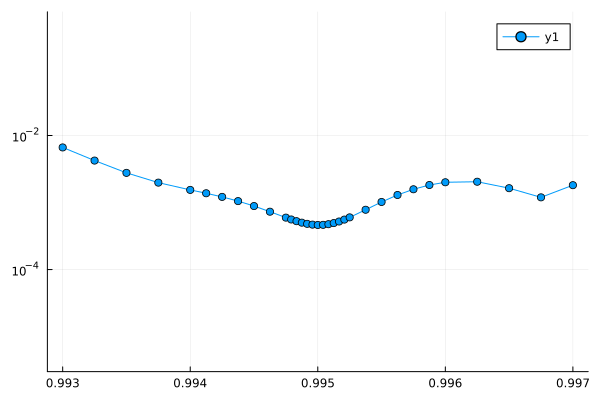

In [26]:
plot(phis,tmp_losses,yscale=:log10,marker="o",ylim=(3e-6,7e-1))

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


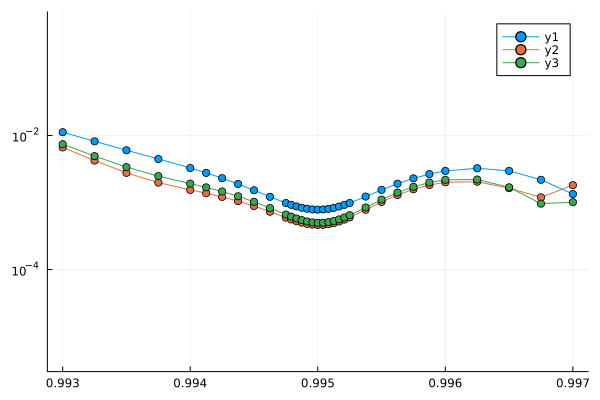

In [36]:
m0loss = readdlm("m0_phi_losses.txt")
m4loss = readdlm("m4_phi_losses.txt")
m5loss = readdlm("m5_phi_losses.txt")

plot(phis,[m4loss,m5loss,tmp_losses],yscale=:log10,marker="o",ylim=(3e-6,7e-1))

In [27]:
# writedlm("phis.txt",phis)
# writedlm("m5_phi_losses.txt",tmp_losses)

In [80]:
using ProgressMeter

In [84]:

# plot(phis,phis,marker="o")

In [85]:
tmp1_losses = []
# tmp2_losses = []
# tmp4_losses = []
tmp3_losses = []

p1 = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p2 = copy(p_new)
# p4 = copy(readdlm("tmp_params5.txt")[end,:])
p3 = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993]

# p3[2] = inv_limit_func(p3[2],0,15)
# p3[1] = inv_limit_func(p3[1],0,15 - p3[2])
# p3[4] = inv_limit_func(p3[4],0.5,1)

# p1[2] = inv_limit_func(p1[2],0,15)
# p1[1] = inv_limit_func(p1[1],0,15 - p1[2])
# p1[4] = inv_limit_func(p1[4],0.5,1)
# @showprogress for phi in [0.99pi, 0.991pi, 0.992pi, 0.993pi, 0.994pi,0.995pi,0.996pi, 0.997pi, 0.998pi, 0.999pi, pi]
@showprogress for phi in phis
    push!(tmp1_losses,fidel(phi*pi,p1))
    # push!(tmp2_losses,fidel(phi*pi,p2))
    # push!(tmp4_losses,fidel(phi*pi,p4))
    push!(tmp3_losses,fidel(phi*pi,p3))
end

Progress:   6%|███                                      |  ETA: 0:07:14

Progress:   9%|████                                     |  ETA: 0:06:49

Progress:  12%|█████                                    |  ETA: 0:06:30

Progress:  15%|███████                                  |  ETA: 0:06:15

Progress:  18%|████████                                 |  ETA: 0:05:58

Progress:  21%|█████████                                |  ETA: 0:05:43

Progress:  24%|██████████                               |  ETA: 0:05:32

Progress:  27%|████████████                             |  ETA: 0:05:19

Progress:  30%|█████████████                            |  ETA: 0:05:06

Progress:  33%|██████████████                           |  ETA: 0:04:53

Progress:  36%|███████████████                          |  ETA: 0:04:39

Progress:  39%|█████████████████                        |  ETA: 0:04:27

Progress:  42%|██████████████████                       |  ETA: 0:04:10

Progress:  45%|███████████████████                      |  ETA: 0:03:53

Progress:  48%|████████████████████                     |  ETA: 0:03:38

Progress:  52%|██████████████████████                   |  ETA: 0:03:23

Progress:  55%|███████████████████████                  |  ETA: 0:03:09

Progress:  58%|████████████████████████                 |  ETA: 0:02:55

Progress:  61%|█████████████████████████                |  ETA: 0:02:41

Progress:  64%|███████████████████████████              |  ETA: 0:02:28

Progress:  67%|████████████████████████████             |  ETA: 0:02:15

Progress:  70%|█████████████████████████████            |  ETA: 0:02:03

Progress:  73%|██████████████████████████████           |  ETA: 0:01:50

Progress:  76%|████████████████████████████████         |  ETA: 0:01:38

Progress:  79%|█████████████████████████████████        |  ETA: 0:01:25

Progress:  82%|██████████████████████████████████       |  ETA: 0:01:13

Progress:  85%|███████████████████████████████████      |  ETA: 0:01:01

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:49

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:36

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:24

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:06:42


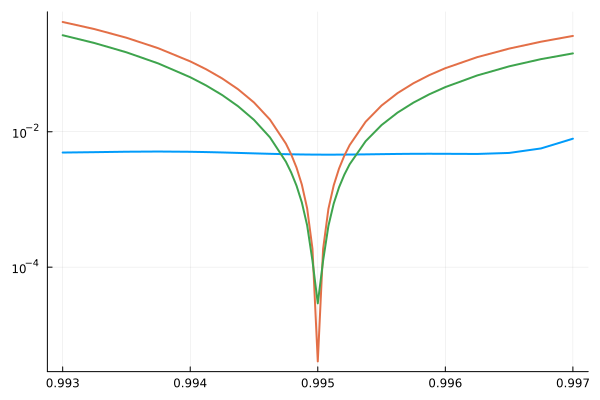

In [103]:
outputplot = plot(phis,[tmp_losses,tmp3_losses,tmp1_losses],yaxis=:log,linewidth=2,legend=nothing)

In [99]:
# savefig(outputplot,"BeautifulRobustness.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\BeautifulRobustness.pdf"

In [102]:
tmp1_losses./ones(11)

11-element Vector{Float64}:
 0.06382200265278937
 0.03991690415735
 0.021853458537448245
 0.00942874507165381
 0.002298652389022937
 2.9160349961532273e-5
 0.002149829165312145
 0.008195945371800739
 0.01773196293944468
 0.030350659263203628
 0.04564560806505197

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


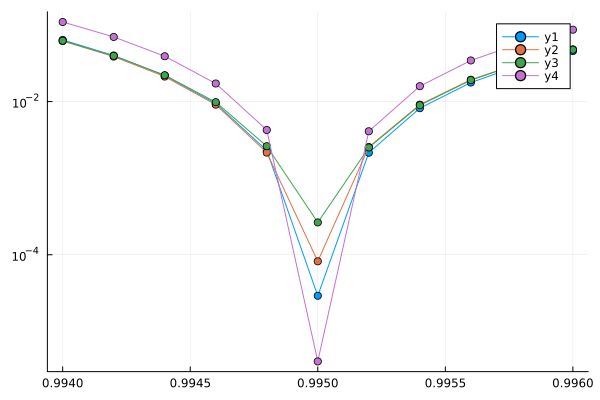

In [94]:
plot(LinRange(0.994,0.996,11),[tmp1_losses,tmp2_losses,tmp4_losses,tmp3_losses],yaxis=:log,marker="o")


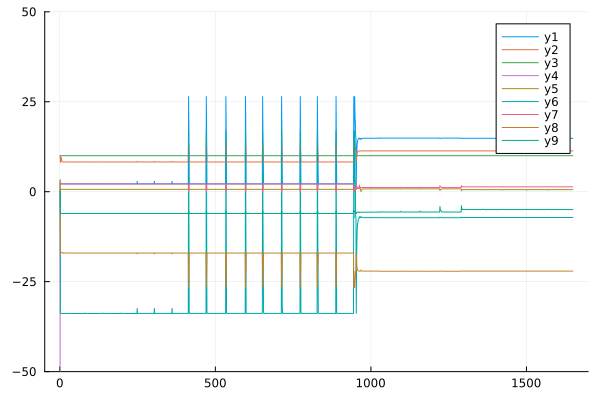

In [146]:
plot(transpose(cat(params...,dims=2)),ylim=(-50,50))


In [200]:
tmp = copy(p_new)
tmp[2] = limit_func(tmp[2],0,15)
tmp[1] = limit_func(tmp[1],0,15 - tmp[2])
tmp

9-element Vector{Float64}:
   1.5263572757019344
  11.472147443938331
  10.0
  -5.188952541845109
   0.6864151876375428
  -7.173438454226289
   0.7024191172650794
 -22.130712303163204
  -8.819182640524026

In [149]:
p_new

9-element Vector{Float64}:
   14.84292607534555
   11.341751839758764
   10.0
 -649.7661732132904
    0.5828557110984577
   -7.161153490188593
    1.3640811715268795
  -22.06506034791423
   -4.957612200539009